In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import pandas as pd
import geopandas as gpd
import geojson
from shapely.geometry import shape
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sodapy import Socrata
import analyze as an

# other dependencies
# - spatialindex (can be installed via homebrew)

pd.options.display.max_columns=999

## 1.1 Obtain data for reported crimes 2017-2018

Data Source: [Chicago Open Data Portal](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2)

In [3]:
domain = 'data.cityofchicago.org'
dataset_id = '6zsd-86xi'

In [4]:
client = Socrata(domain, None)

In [5]:
results = client.get(dataset_id, where="year in (2017, 2018)", limit=1000000)
crimes = pd.DataFrame.from_dict(results)

In [6]:
# convert date column to datetime and use as index
crimes.date = pd.to_datetime(crimes.date)
crimes = crimes.set_index(crimes.date)

In [7]:
crimes.head()

,arrest,beat,block,case_number,community_area,date,description,district,domestic,fbi_code,id,iucr,latitude,location,location_address,location_city,location_description,location_state,location_zip,longitude,primary_type,updated_on,ward,x_coordinate,y_coordinate,year
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-10-08 03:00:00,False,2222,092XX S RACINE AVE,JB147188,73,2017-10-08 03:00:00,NON-AGGRAVATED,022,False,02,11227287,0281,NaN,NaN,NaN,NaN,RESIDENCE,NaN,NaN,NaN,CRIM SEXUAL ASSAULT,2018-02-11T15:57:41.000,21,NaN,NaN,2017
2017-03-28 14:00:00,False,0835,026XX W 79TH ST,JB147595,70,2017-03-28 14:00:00,UNLAWFUL ENTRY,008,False,05,11227583,0620,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,BURGLARY,2018-02-11T15:57:41.000,18,NaN,NaN,2017
2017-09-09 20:17:00,False,0313,060XX S EBERHART AVE,JB147230,42,2017-09-09 20:17:00,OVER $500,003,False,06,11227293,0810,NaN,NaN,NaN,NaN,RESIDENCE,NaN,NaN,NaN,THEFT,2018-02-11T15:57:41.000,20,NaN,NaN,2017
2017-08-26 10:00:00,False,0122,001XX W RANDOLPH ST,JB147599,32,2017-08-26 10:00:00,NON-AGGRAVATED,001,False,02,11227634,0281,NaN,NaN,NaN,NaN,HOTEL/MOTEL,NaN,NaN,NaN,CRIM SEXUAL ASSAULT,2018-02-11T15:57:41.000,42,NaN,NaN,2017
2017-01-01 00:01:00,False,1033,027XX S WHIPPLE ST,JB146365,30,2017-01-01 00:01:00,AGG SEX ASSLT OF CHILD FAM MBR,010,False,02,11227508,1754,NaN,NaN,NaN,NaN,RESIDENCE,NaN,NaN,NaN,OFFENSE INVOLVING CHILDREN,2018-02-11T15:57:41.000,12,NaN,NaN,2017


## 1.2 Summary statistics

### Types of reported crimes

In the 2017-18 period, there are 534,359 crimes reported in total. 
The top 5 reported crime types are theft (24%), battery (19%), criminal damage (11%), assault (7%), and deceptive practice (7%). Together, crimes of these 5 types makeup 68% of all crimes. 

In [8]:
top_reported = an.groupby_major_crime_types(crimes, 0.03)
top_reported.head()

/Users/andyras/git/machine-learning-for-policy/hws/hw1/analyze.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  top_types.loc[new_row, 'Crime Type']  = 'OTHER'


,Crime Type,Number,Percent
0,THEFT,129435,0.242158
1,BATTERY,98998,0.185214
2,CRIMINAL DAMAGE,56848,0.106356
3,ASSAULT,39681,0.074239
4,DECEPTIVE PRACTICE,37829,0.070774


Other top crime types are shown below:

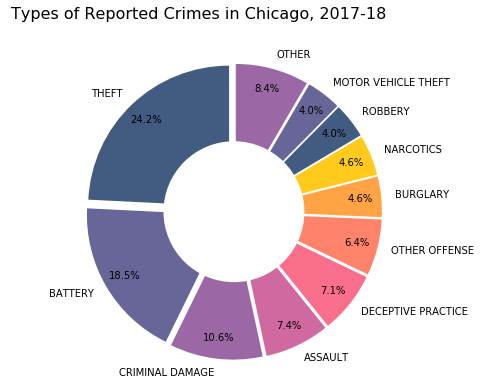

In [9]:
colors = ['#415c80', '#686599', '#9b68a5', '#cf69a0', 
          '#f96e8a', '#ff826a', '#ffa344', '#ffca1c']

an.plot_donut_chart(top_reported, "Crime Type", "Number", 
                    title = "Types of Reported Crimes in Chicago, 2017-18",
                    colors=colors)

### Types of arrests

19.6% (104,943) of the total crimes reported resulted in arrests. The top types of the arrests differ from those of the reports -- narcotics (23%), battery (19%), theft (12%), criminal trespass (7%), and weapons violation (7%). Together, arrests of these 5 types makeup 69% of all arrests.

In [10]:
arrested = crimes.arrest == True

In [11]:
top_arrested = an.groupby_major_crime_types(crimes, 0.03, fil=arrested)
top_arrested.head()

,Crime Type,Number,Percent
0,NARCOTICS,24665,0.234835
1,BATTERY,20263,0.192924
2,THEFT,12770,0.121583
3,CRIMINAL TRESPASS,7820,0.074454
4,WEAPONS VIOLATION,7477,0.071189


In [12]:
# Total arrests
len(crimes[arrested])

105031

In [13]:
# Percentage of reported crimes that resulted in arrests
len(crimes[arrested])/len(crimes)

0.19650070064564168

In [14]:
# Percentage of top 5 arrest types
sum(top_arrested[:5].Percent)

0.6949852900572212

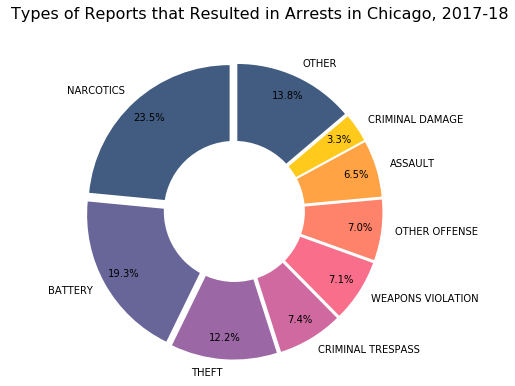

In [15]:
# Plot
an.plot_donut_chart(top_arrested, "Crime Type", "Number", 
                    title = "Types of Reports that Resulted in Arrests in Chicago, 2017-18", 
                    colors=colors)

### Time trends

There are 268,098 crime reports in 2017 and 266,275 in 2018. 
  
Both crimes reports and arrests have the same seasonal patterns in both years: high in summer and low in winter. The number of reports reaches the lowest point and begins rising in February, peaks at August, and goes down in the fall again.

#### Trends of top crime report types 
The numbers of crime reports of theft, battery, criminal damage, and assault have the same seasonal patterns as the overall crime trend. The number of deceptive practices, however, stay roughly the same monthly through out the year.

#### Trends of top arrest types 
The numbers of arrests of theft and battery have the same seasonal patterns as the overall crime/arrest trend. The number of arrests for narcotics, criminal trespass and weapons violation stay roughly the same monthly throughout the year.


In [16]:
# Total number of crimes reported in 2017 and 2018
crimes.groupby("year").size()

year
2017    268118
2018    266389
dtype: int64

In [17]:
# Number of top crime reports in 2017 and 2018
crimes.groupby(['primary_type','year']).size().sort_values(ascending=False).head(10)

primary_type        year
THEFT               2018    65089
                    2017    64346
BATTERY             2018    49784
                    2017    49214
CRIMINAL DAMAGE     2017    29041
                    2018    27807
ASSAULT             2018    20378
                    2017    19303
DECEPTIVE PRACTICE  2017    19046
                    2018    18783
dtype: int64

In [18]:
# Prepare data for plotting time trends
# Create dummy variable for all reported crimes
crimes["reported"] = True
reported = crimes["reported"]

# Create dummy variables for crime types
type_dum = pd.get_dummies(crimes['primary_type'])

# Keep the dummy variables for top 5 types of reported crimes
top_rep_types = list(top_reported['Crime Type'].head())
type_dum_rep = type_dum[top_rep_types]

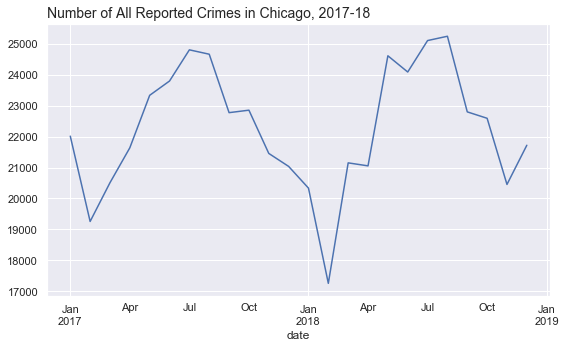

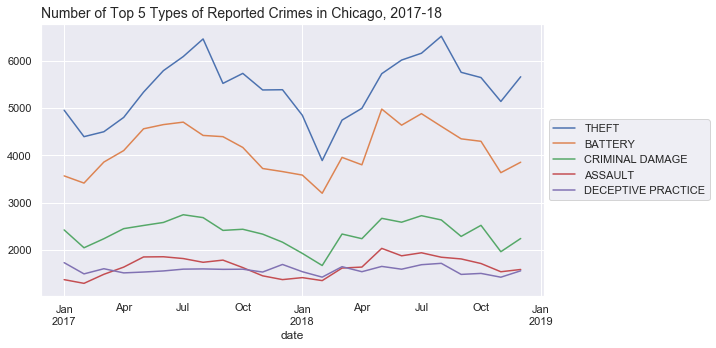

In [19]:
# Plot monthly counts of reported crimes
sns.set(style="darkgrid")

# All reported crimes
reported.resample('M').sum().plot(figsize=(9,5))
plt.title('Number of All Reported Crimes in Chicago, 2017-18', 
          fontdict = {'fontsize': 14}, loc = 'left')

# Top 5 types of reported crimes
type_dum_rep.resample('M').sum().plot(figsize=(9,5)).legend(loc='center left', 
                                                            bbox_to_anchor=(1, 0.5))
plt.title('Number of Top 5 Types of Reported Crimes in Chicago, 2017-18',
         fontdict = {'fontsize': 14}, loc = 'left')
plt.show()

In [20]:
# Keep the dummy variables for top 5 types of arrests
top_arr_types = list(top_arrested['Crime Type'].head())
type_dum_arr = type_dum[top_arr_types]

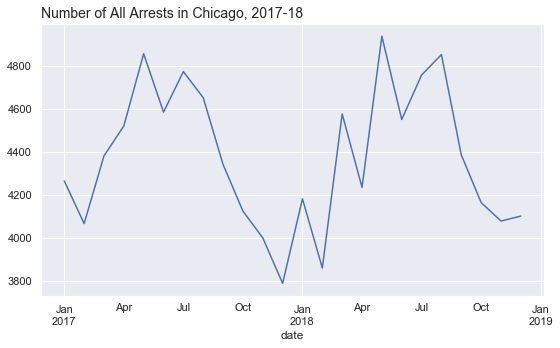

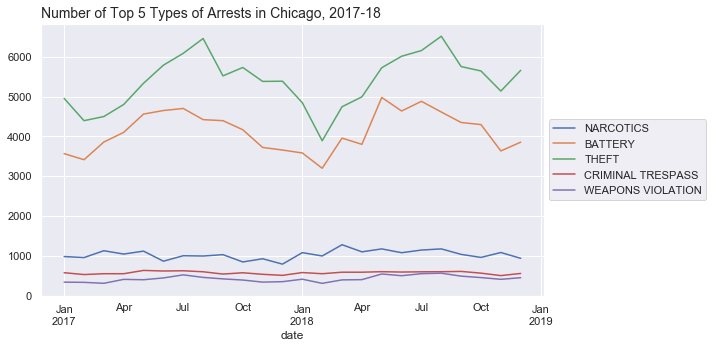

In [21]:
# Plot monthly counts of arrests
arrests = crimes[crimes['arrest'] == True]['arrest']

# All arrests
arrests.resample('M').sum().plot(figsize=(9,5))
plt.title('Number of All Arrests in Chicago, 2017-18',
          fontdict = {'fontsize': 14}, loc = 'left')
# Top 5 types of arrests
type_dum_arr.resample('M').sum().plot(figsize=(9,5)).legend(loc='center left', 
                                                            bbox_to_anchor=(1, 0.5))
plt.title('Number of Top 5 Types of Arrests in Chicago, 2017-18',
          fontdict = {'fontsize': 14}, loc = 'left')
plt.show()

### Neighborhood patterns 

In [22]:
# Load geojson of community areas
gdf = gpd.read_file("data/Boundaries - Community Areas (current).geojson")
gdf.set_index("area_num_1", inplace=True)

In [23]:
# Get counts of reported crimes by community area
num_rep_by_comm = crimes.groupby("community_area").size().to_frame()
num_rep_by_comm.columns = ["num_reported"]

In [24]:
# Get counts of arrests by community area
num_arr_by_comm = crimes[crimes.arrest == True].groupby("community_area").size().to_frame()
num_arr_by_comm.columns = ["num_arrested"]

In [25]:
# Merge counts to community area geodataframe
neighborhood = gdf.merge(num_rep_by_comm, left_index=True, right_index=True)
neighborhood = neighborhood.merge(num_arr_by_comm, left_index=True, right_index=True)

#### Community areas with the highest number of reported crimes:

In [26]:
nb_rep = neighborhood.sort_values('num_reported', ascending=False)[
         ['community', 'num_reported']][:20]
nb_rep.head()

,community,num_reported
25,AUSTIN,30434
8,NEAR NORTH SIDE,25370
32,LOOP,21485
28,NEAR WEST SIDE,18454
29,NORTH LAWNDALE,18382


#### Community areas with the highest number of arrests:

In [27]:
nb_arr = neighborhood.sort_values('num_arrested', ascending=False)[
         ['community', 'num_arrested']][:20]
nb_arr.head()

,community,num_arrested
25,AUSTIN,7799
29,NORTH LAWNDALE,6941
23,HUMBOLDT PARK,5182
8,NEAR NORTH SIDE,4244
26,WEST GARFIELD PARK,4158


#### Chicago Community Areas with Top 20  Number of Reported Crimes, 2017-18:

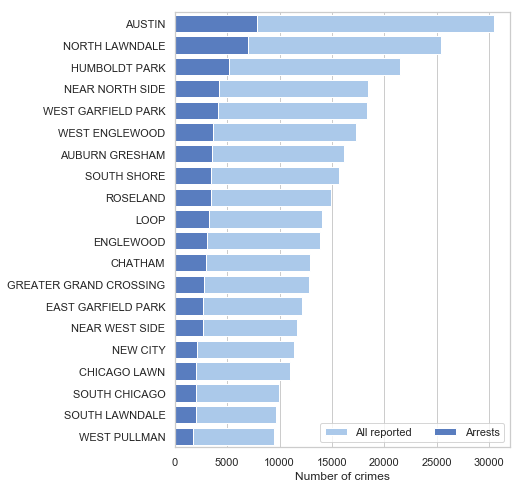

In [28]:
sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 8))

# Plot the total number of crimes reported
sns.set_color_codes("pastel")
sns.barplot(x="num_reported", y="community", data=nb_rep,
            label="All reported", color="b")

# Plot the crimes resulted in arrests
sns.set_color_codes("muted")
sns.barplot(x="num_arrested", y="community", data=nb_arr,
            label="Arrests", color="b")


ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="Number of crimes")
plt.show()

#### Community Area Crime Heat Map, 2017-18:

Crime reports are most concentrated in the West Side and the Downtown neighborhoods. The density of crime reports on the South Side is less, although significantly more than other areas.

Arrests are most concentrated in the West Side neighorhoods. The density of arrests in Downtown and South Side immediately follow and are roughly at the same level with each other.

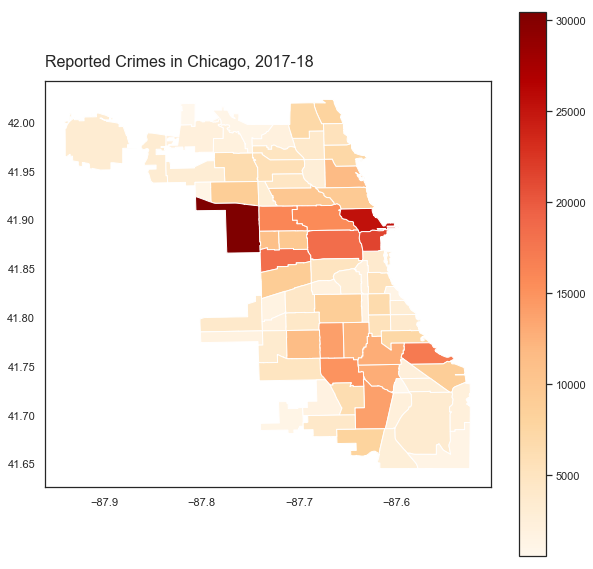

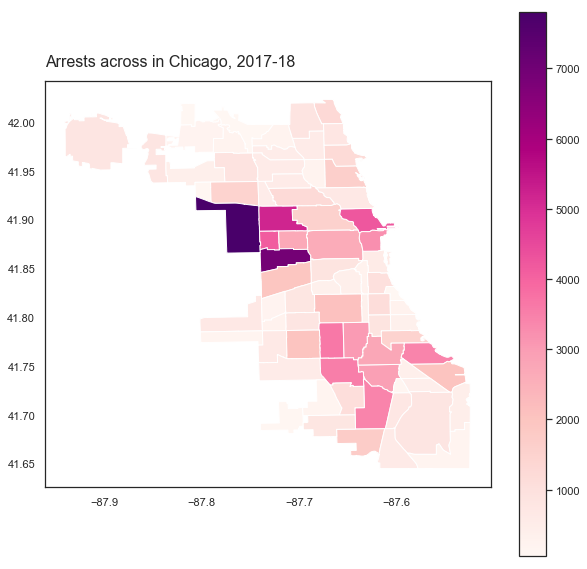

In [29]:
sns.set(style="white")
neighborhood.plot(figsize = (10, 10), column='num_reported', cmap="OrRd", legend=True)
plt.title("Reported Crimes in Chicago, 2017-18", 
         fontdict={'fontsize': 16}, loc='left', pad=15)
plt.show()

neighborhood.plot(figsize = (10, 10), column='num_arrested', cmap="RdPu", legend=True)
plt.title("Arrests across in Chicago, 2017-18", 
          fontdict={'fontsize': 16}, loc='left', pad=15)
plt.show()

## 2.1 Data Augmentation

#### Requesting block group data using Census ACS 5-Year Estimate (2017) API:

In [30]:
# Construct request URL for American Community Survey 5-Year Estimate (2017)
base_url = 'https://api.census.gov/data/2017/acs/acs5?get=NAME,'
varlist = ['B01003_001E', 'B19013_001E','B25003_001E', 'B25003_002E', 'B25003_003E']
base_url += (','.join(varlist))
base_url += '&for=block+group:*&in=state:17+county:031'

In [31]:
# Request and store ACS data
response = requests.get(base_url)
cen = pd.read_json(response.text)
header = ['name', 'population', 'median_income', 'total_tenure', 'owner_occupied', 
          'renter_occupied', 'state', 'county', 'tract', 'block_group']
cen = cen[1:]
cen.columns = header

#### Match each crime report to block group GEOID using its (lat, long) coordinates and the geographical boundaries of Census block groups
  
Note: For the purpose of our analysis, crime reports without coordinates are dropped. Because they only make up 1% of all crime reports, dropping them is not likely to affect the analysis result. To ensure that, however, further analysis on the dropped reports are needed to see whether variables of the dropped reports have similar distribution as those of the entire dataset.

In [32]:
# Percentage of crime reports without coordinates
len(crimes[crimes['location'].isna()])/len(crimes)

0.01120658850117959

In [33]:
# Drop crimes without coordinates and convert to geodataframe
gcrimes = crimes.dropna(subset=['location'])
gcrimes.location = gcrimes.location.apply(lambda x: shape(x))
gcrimes = gpd.GeoDataFrame(gcrimes, geometry='location')

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [34]:
# Read census block groups shapefile
blocks = gpd.read_file('data/censusblocks/cb_2016_17_bg_500k.shp')
blocks_to_join = blocks[['GEOID', 'geometry']]

In [35]:
# Get block group ID for crime report
blocks_to_join.crs = {'init': 'epsg:4326'}
gcrimes.crs = {'init': 'epsg:4326'}
gcrimes = gpd.sjoin(gcrimes, blocks_to_join, how="left", op='intersects')

In [36]:
# Create GEOID in census data from state, county, tract, and block group numbers
cen['GEOID'] = cen.state + cen.county + cen.tract + cen.block_group

In [37]:
# Clean census data for merge
cen = cen.astype({'population': float, 'median_income': float, 'total_tenure': float, 
                  'owner_occupied': float, 'renter_occupied': float})
cen['owner_occupancy_rate'] = cen.owner_occupied / cen.total_tenure
cen_to_merge = cen[['population', 'median_income', 'total_tenure', 'owner_occupied', 
                    'renter_occupied', 'GEOID', 'owner_occupancy_rate']]

In [38]:
# Merge crimes and ACS variables
crimes_cen = gcrimes.merge(cen_to_merge, on='GEOID', how='left')

#### Results

Obtained 2017 ACS 5-Year estimates on *population, median household income, total number of housing, number of owner occupied housing,* and *number of renter occupied housing* for all block groups in Cook County, IL. Calculated owner occupancy rate for each block group.

In [39]:
cen_to_merge.head()

,population,median_income,total_tenure,owner_occupied,renter_occupied,GEOID,owner_occupancy_rate
1,594.0,-666666666.0,284.0,102.0,182.0,170310101001,0.359155
2,2170.0,20716.0,939.0,55.0,884.0,170310101002,0.058573
3,1680.0,63782.0,1025.0,207.0,818.0,170310101003,0.201951
4,1439.0,31782.0,659.0,223.0,436.0,170310102011,0.338392
5,4820.0,36386.0,1599.0,352.0,1247.0,170310102012,0.220138


Merged ACS variables to crime reports dataset.

In [40]:
crimes_cen.head()

,arrest,beat,block,case_number,community_area,date,description,district,domestic,fbi_code,id,iucr,latitude,location,location_address,location_city,location_description,location_state,location_zip,longitude,primary_type,updated_on,ward,x_coordinate,y_coordinate,year,reported,index_right,GEOID,population,median_income,total_tenure,owner_occupied,renter_occupied,owner_occupancy_rate
0,False,1831,002XX W ONTARIO ST,JA101187,8,2017-01-02 02:30:00,SIMPLE,018,False,08B,10802083,0460,41.89318177,POINT (-87.6345943 41.89318177),,,STREET,,,-87.6345943,BATTERY,2017-02-14T15:49:42.000,42,1174494,1904440,2017,True,2014.0,170310818002,3760.0,118922.0,2385.0,1214.0,1171.0,0.509015
1,False,1113,044XX W MAYPOLE AVE,JA102131,26,2017-01-02 21:30:00,$500 AND UNDER,011,False,06,10802821,0820,41.88456033,POINT (-87.735909158 41.88456033),,,STREET,,,-87.735909158,THEFT,2017-02-14T15:49:42.000,28,1146931,1901090,2017,True,6126.0,170312604001,1292.0,18218.0,397.0,88.0,309.0,0.221662
2,False,1733,033XX N KIMBALL AVE,JA102673,21,2017-01-01 00:15:00,OVER $500,017,False,06,10803908,0810,41.942040816,POINT (-87.712587544 41.942040816),,,OTHER,,,-87.712587544,THEFT,2017-02-14T15:49:42.000,35,1153130,1922081,2017,True,6254.0,170318311001,1318.0,60083.0,507.0,218.0,289.0,0.429980
3,False,1713,050XX N SAWYER AVE,JA103557,14,2017-01-04 02:30:00,SIMPLE,017,False,08A,10804280,0560,41.972629241,POINT (-87.70981573 41.972629241),,,STREET,,,-87.70981573,ASSAULT,2017-02-14T15:49:42.000,39,1153803,1933233,2017,True,9084.0,170311402001,2768.0,54602.0,513.0,174.0,339.0,0.339181
4,False,0533,006XX E 138TH ST,JA105339,54,2017-01-04 15:00:00,TO RESIDENCE,005,False,26,10806428,1365,41.644606368,POINT (-87.606301217 41.644606368),,,APARTMENT,,,-87.606301217,CRIMINAL TRESPASS,2017-02-14T15:49:42.000,9,1182963,1813925,2017,True,5873.0,170318264012,1689.0,41350.0,581.0,292.0,289.0,0.502582


## 2.2 Block Characteristics

### i) Battery
Battery reports are more likely on blocks with:

- larger population
- lower median household income
- lower owner occupancy rate

The Loop (block group with GEOID 170318391001) has the most number of batteries. It is dropped as an outlier for the calculation of the descriptive statistics. Because there are a large number of blocks with battery reports (over 2000), dropping one block does not affect analysis of the block characteristics.

In [41]:
bat = an.get_crime_type_data('BATTERY', crimes_cen)

In [120]:
# Blocks with most battery reports
bat_bg = an.get_top_blocks(bat)
bat_bg.head()

2242
2241
2241
2232


,GEOID,count,population,number
0,170318391001,563,4164.0,563
1,170310817002,344,2211.0,344
2,170313204001,332,3167.0,332
3,170318387001,314,2473.0,314
4,170312705001,304,1690.0,304


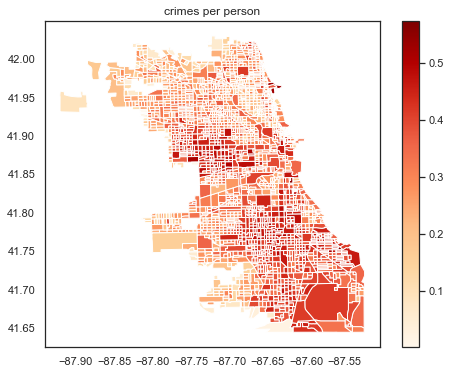

In [130]:
# Map blocks with most battery reports
an.map_blocks(bat_bg, blocks)

        population  median_income  owner_occupancy_rate
mean   1277.955273   57338.523070              0.476431
std     612.345177   32611.296005              0.237965
min     125.000000    6286.000000              0.000000
25%     870.000000   33919.000000              0.304214
50%    1180.500000   49837.000000              0.454141
75%    1565.500000   72592.750000              0.639524
max   10079.000000  211071.000000              1.000000


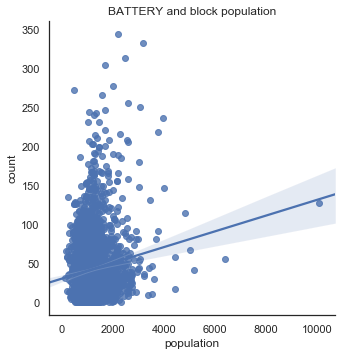

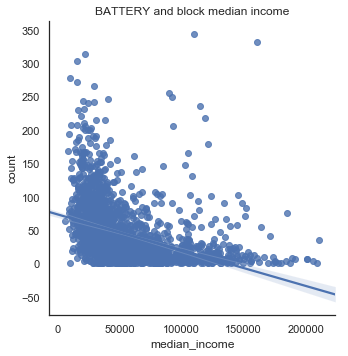

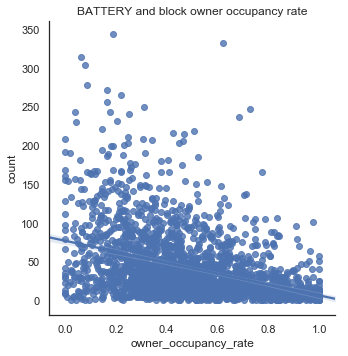

In [44]:
# Get summary stats on block group ACS variables and their correlation with the number of crimes in the block
an.describe_blocks('BATTERY', bat_bg, cen_to_merge, outliers = ['170318391001'])

### ii) Homicide
Homicide reports are more likely on blocks with lower median household income (under 100k).  
Owner occupancy rate has a weak negative correlation with number of homicide reports.

In [45]:
hom = an.get_crime_type_data('HOMICIDE', crimes_cen)

In [46]:
# Blocks with most homicide reports
hom_bg = an.get_top_blocks(hom)
hom_bg.head()

,GEOID,count
0,170318346004,12
1,170314906001,10
2,170318434001,9
3,170318387001,8
4,170312519002,7


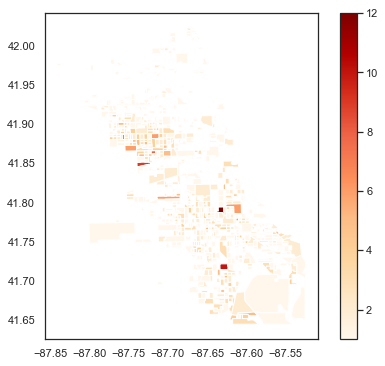

In [47]:
# Map blocks with most homicide reports
an.map_blocks(hom_bg, blocks)

        population  median_income  owner_occupancy_rate
mean   1265.470769   39177.458462              0.394231
std     669.985741   21881.287323              0.217164
min     125.000000    6286.000000              0.000000
25%     839.000000   25045.000000              0.229338
50%    1189.500000   34591.500000              0.376593
75%    1547.750000   46974.000000              0.532522
max   10079.000000  171429.000000              1.000000


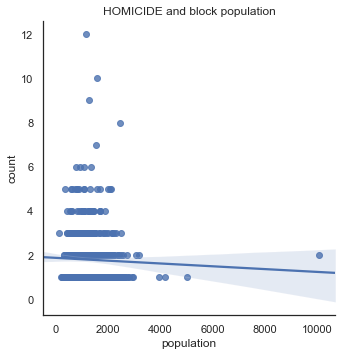

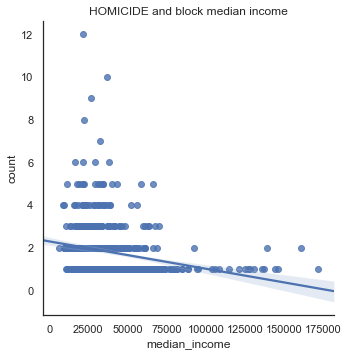

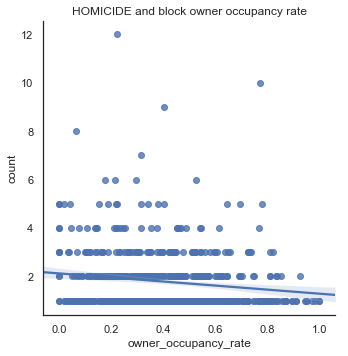

In [48]:
# Get summary stats on block group ACS variables and their correlation with the number of crimes in the block
an.describe_blocks("HOMICIDE", hom_bg, cen_to_merge)

### iii) Battery and Homicde in 2017 vs. 2018

Block characteristics for battery reports stayed the stame from 2017 to 2018.

In [49]:
bat17 = an.get_crime_type_data('BATTERY', crimes_cen, year='2017')
bat_bg17 = an.get_top_blocks(bat17)
an.describe_blocks('BATTERY', bat_bg17, cen_to_merge, outliers=['170318391001'],
                   plot=False)

        population  median_income  owner_occupancy_rate
mean   1280.532562   56777.268210              0.473198
std     616.288212   32141.779737              0.235569
min     125.000000    6286.000000              0.000000
25%     870.000000   33661.000000              0.302326
50%    1183.000000   49271.000000              0.452328
75%    1572.000000   72171.000000              0.635350
max   10079.000000  211071.000000              1.000000


In [50]:
bat18 = an.get_crime_type_data('BATTERY', crimes_cen, year='2018')
bat_bg18 = an.get_top_blocks(bat18)
an.describe_blocks('BATTERY', bat_bg18, cen_to_merge, outliers=['170318391001'],
                   plot=False)

        population  median_income  owner_occupancy_rate
mean   1280.920057   56769.247966              0.472130
std     615.559862   32033.775258              0.236029
min     125.000000    6286.000000              0.000000
25%     870.000000   33672.000000              0.301294
50%    1182.000000   49427.000000              0.451662
75%    1572.000000   71833.000000              0.635054
max   10079.000000  211071.000000              1.000000


Homicide reports in 2018 are in blocks with slightly smaller population, lower median household income, and lower occupancy rate on average. The median household income of blocks with homicides are a little more spreadout (higher standard deviation) in 2018.

In [51]:
hom17 = an.get_crime_type_data('HOMICIDE', crimes_cen, year='2017')
hom_bg17 = an.get_top_blocks(hom17)
an.describe_blocks('HOMICIDE', hom_bg17, cen_to_merge, plot=False)

        population  median_income  owner_occupancy_rate
mean   1265.534442   38086.686461              0.394144
std     709.861802   20755.980297              0.217545
min     125.000000    8704.000000              0.000000
25%     833.000000   24750.000000              0.229851
50%    1191.000000   33882.000000              0.375000
75%    1533.000000   45853.000000              0.544643
max   10079.000000  171429.000000              0.985612


In [52]:
hom18 = an.get_crime_type_data('HOMICIDE', crimes_cen, year='2018')
hom_bg18 = an.get_top_blocks(hom18)
an.describe_blocks('HOMICIDE', hom_bg18, cen_to_merge, plot=False)

       population  median_income  owner_occupancy_rate
mean  1236.371429   37325.441558              0.373183
std    550.222365   21263.928942              0.213163
min    125.000000    6286.000000              0.000000
25%    858.000000   23974.000000              0.217910
50%   1166.000000   32102.000000              0.352798
75%   1517.000000   42222.000000              0.504651
max   4164.000000  160833.000000              1.000000


### iv) Deceptive Practice vs. Sex Offense

#### Deceptive practice reports are significantly more likely to be in blocks with a large population, and are most concentrated in the Loop.

In the Loop, the number of deceptive practice reports are 87x and more than 35 standard deviations from the block group average city-wide.

The other places in the top are other parts of Downtown and the O'Hare International Airport.


This makes sense because a huge amount of transient population, including tourists, flow in and out the areas daily, making better conditions for deceptive practices.

In [53]:
dp = an.get_crime_type_data('DECEPTIVE PRACTICE', crimes_cen)

In [54]:
dp_bg = an.get_top_blocks(dp)
dp_bg.head()

,GEOID,count
0,170318391001,1401
1,170313204001,507
2,170319800001,385
3,170313201002,366
4,170310815003,345


In [55]:
dp_bg.describe()

,count
count,2216.000000
mean,16.075361
std,39.416789
min,1.000000
25%,6.000000
50%,11.000000
75%,16.250000
max,1401.000000


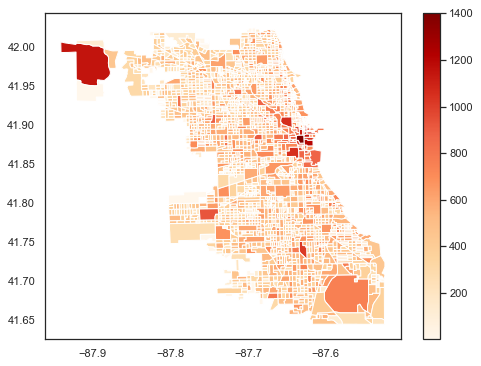

In [86]:
an.map_blocks(dp_bg, blocks)

Deceptive reports are more likely on blocks with a larger population.

Median income and owner occupancy rate has little correlation with deceptive practice.

        population  median_income  owner_occupancy_rate
mean   1279.169048   57404.228571              0.475268
std     614.468477   32559.878292              0.238613
min     125.000000    6286.000000              0.000000
25%     869.750000   33849.000000              0.302312
50%    1182.000000   49907.000000              0.453009
75%    1568.250000   72860.250000              0.639336
max   10079.000000  211071.000000              1.000000


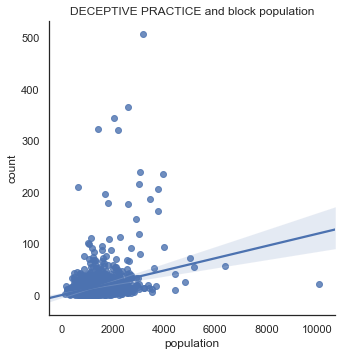

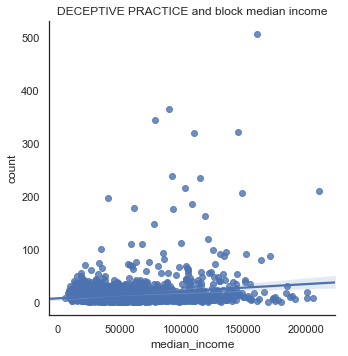

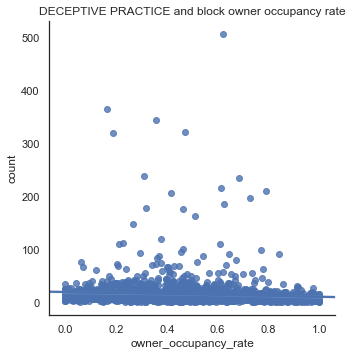

In [57]:
an.describe_blocks('DECEPTIVE PRACTICE', dp_bg, cen_to_merge, 
                   outliers = ['170318391001'])

#### Sex offense reports are 1) a little more spread out geographically than deceptive practices and 2) more likely in blocks with lower owner occupancy rate

In [58]:
so = an.get_crime_type_data('SEX OFFENSE', crimes_cen)

In [59]:
so_bg = an.get_top_blocks(so)
so_bg.head()

,GEOID,count
0,170318391001,16
1,170313204001,16
2,170313201002,11
3,170318391002,9
4,170310817002,9


In [60]:
so_bg.describe()

,count
count,1105.000000
mean,1.808145
std,1.390094
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,16.000000


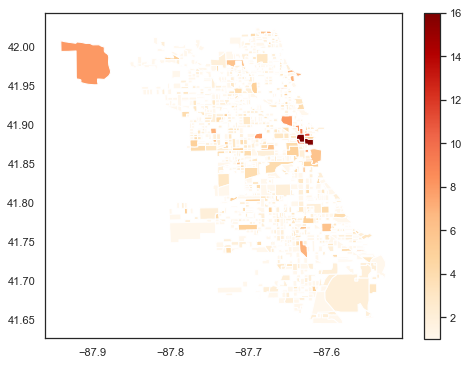

In [61]:
an.map_blocks(so_bg, blocks)

Sex offense reports are more likely on blocks with:
- larger population 
- lower owner occupancy rate  

Median income has little correlation with sex offense.

        population  median_income  owner_occupancy_rate
mean   1357.827125   52601.377268              0.424127
std     681.428538   31145.940222              0.220439
min     125.000000    6286.000000              0.000000
25%     926.000000   31192.000000              0.260756
50%    1259.000000   44573.000000              0.407216
75%    1651.500000   66464.000000              0.558447
max   10079.000000  211071.000000              1.000000


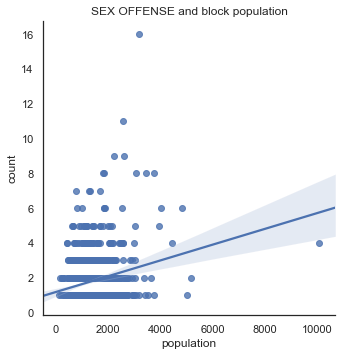

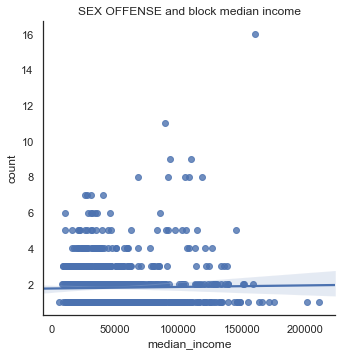

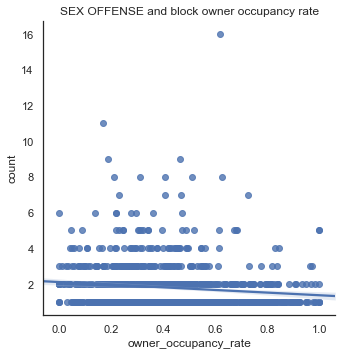

In [62]:
an.describe_blocks('SEX OFFENSE', so_bg, cen_to_merge, 
                   outliers = ['170318391001'])

## 3.1 How did crime change in Chicago from 2017 to 2018

The number of crime reports decreased by 1,823 from 2017 to 2018. In the top 5 types of crimes, the total number of crime reports stayed roughly the same.
                    

Both crimes reports and arrests have the same seasonal patterns in both years: high in summer and low in winter. The number of reports reaches the lowest point and begins rising in February, peaks at August, and goes down in the fall again. 

Crime fluctuated a little more in 2018 -- the total number is lower in April and higher in May 2018 compared to the same months in 2017.


                    



## 3.2 Evaluation of Candidate's Statistics

In [63]:
# Get crimes data for 43rd Ward during the 28-day period in 2017 and in 2018
crimes18 = crimes[crimes.ward == '43']['2018-06-28':'2018-07-26']
crimes17 = crimes[crimes.ward == '43']['2017-06-28':'2017-07-26']

The statistics are incorrect.  

The percentage changes in each crime type reported for 43rd Ward during the same 28-day period in 2017 and in 2018 are calculated below:

Robberies: down 52.9%. The candidate's statement about the rise in crime is incorrect.

In [64]:
rob17 = an.get_crime_type_data('ROBBERY', crimes17)
rob18 = an.get_crime_type_data('ROBBERY', crimes18)
print('2018:', len(rob18))
print('2017:', len(rob17))
(len(rob18) - len(rob17)) / len(rob17)

2018: 8
2017: 17


-0.5294117647058824

Batteries: down 14.6%. The candidate's statement about the rise in crime is incorrect.

In [65]:
bat17 = an.get_crime_type_data('BATTERY', crimes17)
bat18 = an.get_crime_type_data('BATTERY', crimes18)
print('2018:', len(bat18))
print('2017:', len(bat17))
(len(bat18) - len(bat17)) / len(bat17)

2018: 35
2017: 41


-0.14634146341463414

Burglaries: down 12.5%. The candidate's statement about the rise in crime is incorrect.

In [66]:
bur17 = an.get_crime_type_data('BURGLARY', crimes17)
bur18 = an.get_crime_type_data('BURGLARY', crimes18)
print('2018:', len(bur18))
print('2017:', len(bur17))
(len(bur18) - len(bur17)) / len(bur17)

2018: 14
2017: 16


-0.125

Motor Vehicle theft: up 66.7%. The candidate's statistics is understated.

In [67]:
mvt17 = an.get_crime_type_data('MOTOR VEHICLE THEFT', crimes17)
mvt18 = an.get_crime_type_data('MOTOR VEHICLE THEFT', crimes18)
print('2018:', len(mvt18))
print('2017:', len(mvt17))
(len(mvt18) - len(mvt17)) / len(mvt17)

2018: 10
2017: 6


0.6666666666666666

All crimes: up 10%. The candidate's statistics is overstated.

In [68]:
(len(crimes18) - len(crimes17)) / len(crimes17) 

0.09971509971509972

The number of all crimes in 43rd Ward rose by 10% from 2017 to 2018. The candidate's statistics is correct.

In [69]:
# Percentage change of all crimes data for 43rd Ward in 2017 and 2018
crimes18_tot = crimes[crimes.ward == '43']['2018-01-01':'2018-12-31']
crimes17_tot = crimes[crimes.ward == '43']['2017-01-01':'2017-12-31']
(len(crimes18_tot) - len(crimes17_tot)) / len(crimes17_tot) 

0.07584830339321358

The statistics the candidate give are misleading. Although he described the overall direction of change in crimes correctly, he gave false directions of violent crimes. The candidate showed drastic increases in major violent crimes, when in reality these crime types reduced. Such statement significantly overstated the extent of the violence and mistated the changes in public safety in the neighborhoods.

## 3.3 Key Findings

- Crimes rise from February and peaks at August.
- Batteries are more likely to occur at blocks with lower median household income and lower owner occupancy rate.
- Violent crimes (batteries and homicides) are concentrated on the West Side, especially in the Austin community area. 
- Crime reports in the Loop are less likely to result in arrests than those on the West and South Side of Chicago.
- O'Hare Airport have a large number of crime reports, including batteries, deceptive practice and sex offense.

The mayor should focus preventative public safety efforts on the West Side of Chicago, especially in Austin. There should be a larger effort during the warmer months. In addition, the mayor should allocate resources for safety issues in the O'Hare International airport.

## 3.4 Major Caveats

- There might be crimes that are not reported. Certain crime types, such as sex offense, are more prone to this issue than others.
- Reported crime might contain false information / are false alarms due to human error or discrimination.
- Around 5800 crime reports are dropped from the analysis because they do not have location coordinates. Because they only make up 1% of all crime reports, dropping them is not likely to affect the result by a large extent. To ensure that, however, further analysis on the dropped reports are needed to see whether variables of the dropped reports have similar distribution as those of the entire dataset.
- For analyses for the dataset augmented with ACS variables, with NA values for median household income are dropped. To ensure that we didn't create bias in our sample by dropping median income, we need to make sure than the missing values of median household income are not correlated with our dependent variable -- crime activities in the block group.

## 4A. 

Based on the data we have, the call is mostly likely a theft. The probabilities for the call to be theft is 29.4%. See below for the calculations.

The block group for 2111 S Michigan Ave, Chicago, IL has the GEOID 170313301004.  

In [71]:
import censusgeocode as cg

In [72]:
result = cg.onelineaddress('2111 S Michigan Ave, Chicago, IL')
loc = result[0]['coordinates']
point = Point(loc['x'], loc['y'])

In [73]:
# Find the block group for using the lat, long of the address
blocks[blocks.geometry.apply(lambda x: point.within(x))]

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
7945,17,031,330100,4,1500000US170313301004,170313301004,4,BG,2001061,828956,"POLYGON ((-87.627146 41.855447, -87.619101 41...."


The crime report types for this block group and the probabilities for them are:

In [74]:
call_block = gcrimes[gcrimes.GEOID == '170313301004']
call_types = call_block.groupby('primary_type').size().sort_values(ascending=False).reset_index()
call_types.columns = ['crime_type', 'count']
call_types['probability'] = call_types['count'] / len(call_block)
call_types

,crime_type,count,probability
0,THEFT,229,0.294344
1,BATTERY,147,0.188946
2,DECEPTIVE PRACTICE,93,0.119537
3,CRIMINAL DAMAGE,63,0.080977
4,OTHER OFFENSE,55,0.070694
5,ASSAULT,45,0.057841
6,ROBBERY,30,0.038560
7,MOTOR VEHICLE THEFT,29,0.037275
8,CRIMINAL TRESPASS,29,0.037275
9,BURGLARY,25,0.032134


## 4B. 

A call about theft is 0.4% more likely to be from Garfield Park. 

In [75]:
# Match crime reports to community area names 
gcrimes.drop(columns=['index_right'], inplace=True)
gcrimes_nbh = gpd.sjoin(gcrimes, gdf, how='left', op='intersects')

In [76]:
thefts = gcrimes_nbh[gcrimes_nbh.primary_type == 'THEFT']
thefts_gu = thefts.groupby('community').size()[
            ['WEST GARFIELD PARK', 'EAST GARFIELD PARK', 'UPTOWN']].reset_index()
thefts_gu.columns = ['community', 'num_thefts']

In [77]:
thefts_gu

,community,num_thefts
0,WEST GARFIELD PARK,1184
1,EAST GARFIELD PARK,1309
2,UPTOWN,1956


In [78]:
# Combine west and east garfield park
thefts_gu.loc[3, 'community'] = 'GARFIELD PARK'
thefts_gu.iloc[3, 1:] = thefts_gu.iloc[0, 1:] + thefts_gu.iloc[1, 1:] 
thefts_gu = thefts_gu.loc[[2,3], :]

In [79]:
# Calculate likelihood
thefts_gu['likelihood'] = thefts_gu['num_thefts'] / len(thefts)
thefts_gu.set_index('community', inplace=True)
thefts_gu

,num_thefts,likelihood
community,,
UPTOWN,1956.0,0.015328
GARFIELD PARK,2493.0,0.019536


In [80]:
# Calculate difference in likelihood
thefts_gu.loc['GARFIELD PARK', 'likelihood'] - thefts_gu.loc['UPTOWN', 'likelihood']

0.004208068206751717

## 4C.

23.1% less likely it came from Garfield Park vs. Uptown  
  
$P(G) = 600 / 1000 = 6 / 10$  
$P(U) = 400 / 1000 = 4 / 10$  
$P(Bat|G) = 100 / 600 = 1 / 6$  
$P(Bat|U) = 160 / 400 = 4 / 10$

$P(Bat) = P(Bat|G) * P(G) + P(Bat|U) * P(U)$  
$P(Bat) = (1/6)(6/10) + (4/10)(4/10) = 26/100$

$P(G|Bat) = (P(G) * (Bat|G)) / P(Bat) = ((6/10) * (1/6)) / (26/100) = 10/26$
$P(U|Bat) = (P(U) * (Bat|U)) / P(Bat) = ((4/10) * (4/10)) / (26/100) = 16/26$


In [81]:
# How much more/less likely it came from Garfield Park:
# 𝑃(𝐺|𝐵𝑎𝑡) - 𝑃(𝑈|𝐵𝑎𝑡)
10/26 - 16/26

-0.23076923076923078